# My Notebook

### 1. Import Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import linear_model, metrics, model_selection
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from ipywidgets import widgets

### 2. Explore Data

#### 2.1 Import Data

In [112]:
# datasets from Michael Bryant
# https://www.kaggle.com/datasets/michaelbryantds/internet-speeds-and-prices
df1 = pd.read_csv("data/speed_price_att_other_cities.csv")
df2 = pd.read_csv("data/speed_price_att.csv")
df3 = pd.read_csv("data/speed_price_centurylink.csv")
df4 = pd.read_csv("data/speed_price_earthlink.csv")
df5 = pd.read_csv("data/speed_price_verizon.csv")
df = pd.concat([df1, df2, df3, df4, df5])

(rows, cols) = df.shape
print("{} Rows x {} Columns".format(rows, cols))
df.head()

1500880 Rows x 7 Columns


,major_city,state,provider,speed_down,speed_up,speed_unit,price
0,cleveland,OH,AT&T,0.768,0.384,Mbps,55.0
1,cleveland,OH,AT&T,0.000,0.000,NaN,NaN
2,cleveland,OH,AT&T,0.000,0.000,NaN,NaN
3,cleveland,OH,AT&T,0.000,0.000,NaN,NaN
4,cleveland,OH,AT&T,0.000,0.000,NaN,NaN


#### 2.2 Summarize ISP Classifications

<Axes: xlabel='provider', ylabel='count'>

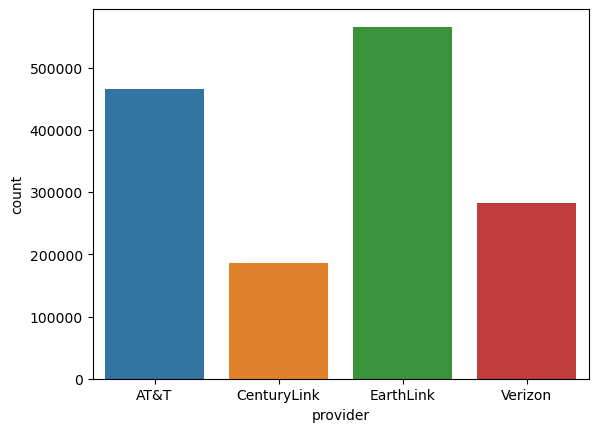

In [113]:
sns.countplot(x="provider", data=df)

### 3. Prepare Data

#### 3.1 Remove Extraneous Columns

In [114]:
df = df.drop(columns=["state", "speed_unit", "price"])
df.head()

,major_city,provider,speed_down,speed_up
0,cleveland,AT&T,0.768,0.384
1,cleveland,AT&T,0.000,0.000
2,cleveland,AT&T,0.000,0.000
3,cleveland,AT&T,0.000,0.000
4,cleveland,AT&T,0.000,0.000


#### 3.2 Remove Cities Outside of Target Markets

In [116]:
target_markets = ["new york", "los angeles", "chicago", "houston", "phoenix"]
(before_rows, _) = df.shape
df = df[df["major_city"].isin(target_markets)]
(after_rows, _) = df.shape
print(str(before_rows - after_rows) + " rows removed.")
df.head()

0 rows removed.


,major_city,provider,speed_down,speed_up
13068,los angeles,AT&T,50.0,10.0
13069,los angeles,AT&T,50.0,10.0
13070,los angeles,AT&T,75.0,20.0
13071,los angeles,AT&T,25.0,5.0
13072,los angeles,AT&T,100.0,20.0


#### 3.3 Reorder Columns

In [117]:
df = df[["major_city", "speed_down", "speed_up", "provider"]]
df.head()

,major_city,speed_down,speed_up,provider
13068,los angeles,50.0,10.0,AT&T
13069,los angeles,50.0,10.0,AT&T
13070,los angeles,75.0,20.0,AT&T
13071,los angeles,25.0,5.0,AT&T
13072,los angeles,100.0,20.0,AT&T


#### 3.4 Remove Invalid Rows

Remove rows containing **0** as the upload speed or download speed.

In [118]:
(before_rows, _) = df.shape
df = df[(df != 0).all(1)]
(after_rows, _) = df.shape
print(str(before_rows - after_rows) + " rows removed.")
df.head()

115766 rows removed.


,major_city,speed_down,speed_up,provider
13068,los angeles,50.0,10.0,AT&T
13069,los angeles,50.0,10.0,AT&T
13070,los angeles,75.0,20.0,AT&T
13071,los angeles,25.0,5.0,AT&T
13072,los angeles,100.0,20.0,AT&T


#### 3.5 Sample Data

Take a subset of the data for improved performance.

In [119]:
(rows, cols) = df.shape
print("Reduced {} Rows x {} Columns".format(rows, cols))
df = df.sample(50000)
(rows, cols) = df.shape
print("to {} Rows x {} Columns".format(rows, cols))
df.head()

Reduced 299229 Rows x 4 Columns
to 50000 Rows x 4 Columns


,major_city,speed_down,speed_up,provider
30690,phoenix,15.0,0.75,EarthLink
362109,houston,300.0,300.00,AT&T
11448,phoenix,10.0,0.75,CenturyLink
17055,los angeles,25.0,5.00,AT&T
506112,houston,100.0,100.00,EarthLink


#### 3.6 Encode City Labels

Convert city strings into numbers for later use in the model.

In [120]:
le = LabelEncoder()
df["major_city_encoded"] = le.fit_transform(df["major_city"])
city_encodings = dict()
for city in df["major_city"].unique():
    encoding = df[df["major_city"] == city]["major_city_encoded"].values[1]
    city_encodings[city] = encoding
cities = []
for city in city_encodings:
    cities.append(city.title())
cities.sort()
df["major_city"] = df["major_city_encoded"]
df = df.drop("major_city_encoded", axis=1)
df.head(10)

,major_city,speed_down,speed_up,provider
30690,4,15.0,0.75,EarthLink
362109,1,300.0,300.00,AT&T
11448,4,10.0,0.75,CenturyLink
17055,2,25.0,5.00,AT&T
506112,1,100.0,100.00,EarthLink
390699,1,300.0,300.00,AT&T
180393,0,75.0,8.00,EarthLink
487931,1,100.0,100.00,EarthLink
61953,2,100.0,100.00,EarthLink
59366,2,6.0,1.00,EarthLink


### 4. Further Data Exploration

#### 4.1 Feature Distribution

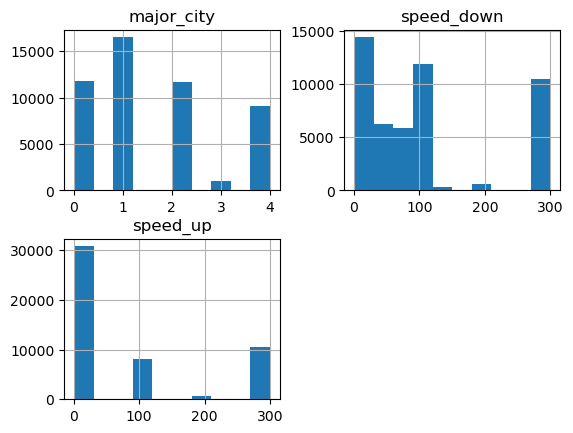

In [121]:
df.hist()
plt.show()

#### 4.2 Feature Relationships

array([[<Axes: xlabel='major_city', ylabel='major_city'>,
        <Axes: xlabel='speed_down', ylabel='major_city'>,
        <Axes: xlabel='speed_up', ylabel='major_city'>],
       [<Axes: xlabel='major_city', ylabel='speed_down'>,
        <Axes: xlabel='speed_down', ylabel='speed_down'>,
        <Axes: xlabel='speed_up', ylabel='speed_down'>],
       [<Axes: xlabel='major_city', ylabel='speed_up'>,
        <Axes: xlabel='speed_down', ylabel='speed_up'>,
        <Axes: xlabel='speed_up', ylabel='speed_up'>]], dtype=object)

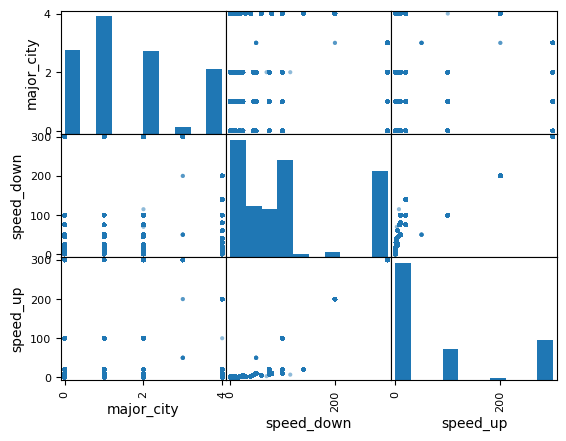

In [122]:
scatter_matrix(df)

### 5. Prepare Data for Machine Learning

Split data into 70% training data and 30% testing data.

In [123]:
y = df.values[:, 3]  # dependent variable (prediction)
X = df.values[:, 0:3]  # independent variables (used to make prediction)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
print("Training data shape: ", X_train.shape)
print("Testing data has shape: ", X_test.shape)

Training data shape:  (35000, 3)
Testing data has shape:  (15000, 3)


### 6. Logistic Regression Model

#### 6.1 Create Logistic Regression Model

In [124]:
log_model = linear_model.LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

#### 6.2 Calculate Model Accuracy

In [125]:
y_pred_log = log_model.predict(X_test)
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_pred_log) * 100, 2), "%")

Accuracy:  71.45 %


#### 6.3 Confusion Matrix

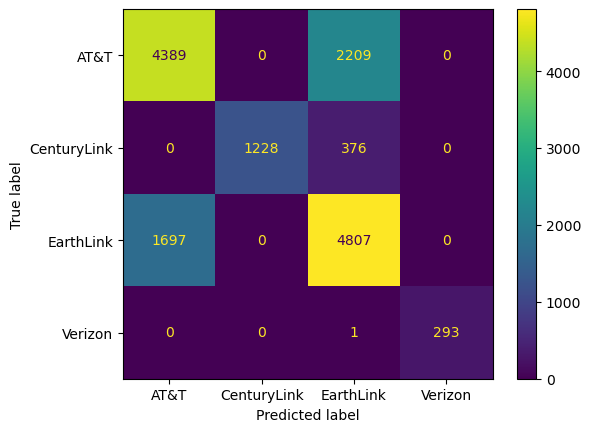

In [126]:
cm = metrics.confusion_matrix(y_test, y_pred_log, labels=log_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()

### 7. Make Prediction

Run the code below to predict a potential customer's current ISP based on the city they live in and their download and upload speed.

In [2]:
city_widget = widgets.Dropdown(options=cities)
download_widget = widgets.FloatSlider(
    value=0.5, min=0.5, max=1000, step=0.1, orientation="horizontal", readout=True, readout_format=".1f"
)
upload_widget = widgets.FloatSlider(
    value=0.5, min=0.5, max=1000, step=0.1, orientation="horizontal", readout=True, readout_format=".1f"
)

button_predict = widgets.Button(description="Predict Current ISP")
button_output = widgets.Label(value='Enter values and press the "Predict" button.')


def on_click(b):
    encoded_city = city_encodings[city_widget.value.lower()]
    prediction = log_model.predict([[encoded_city, download_widget.value, upload_widget.value]])
    button_output.value = "Predicted ISP: " + str(prediction[0])


button_predict.on_click(on_click)

label_layout = widgets.Layout(width="110px")
vb = widgets.VBox(
    [
        widgets.HBox([widgets.Label("City:", layout=label_layout), city_widget]),
        widgets.HBox([widgets.Label("Download Speed:", layout=label_layout), download_widget, widgets.Label("Mbps")]),
        widgets.HBox([widgets.Label("Upload Speed:", layout=label_layout), upload_widget, widgets.Label("Mbps")]),
        widgets.HBox([widgets.Label(" ", layout=label_layout), button_predict]),
        widgets.HBox([widgets.Label(" ", layout=label_layout), button_output]),
    ]
)
print("\033[1m" + "Select values and make a prediction" + "\033[0m")
display(vb)

NameError: name 'cities' is not defined